# DEMO 2: Real-World Data

Intro text...

## Package Imports and Initial Setup

In [1]:
import src.coorddescent as cd

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Data Import and Standardization

In [2]:
# hitters = pd.read_csv('./data/Hitters.csv', sep=',', header=0)
hitters = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv', sep=',', header=0)
hitters = hitters.dropna()

# split out predictors and response
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

# Encode the variables League, Division, and NewLeague
X = pd.get_dummies(X, drop_first=True)

# train/test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

# scale and center predictors
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

# scale and center response
y_train_mean = np.mean(y_train)
y_train_sd = np.std(y_train)
y_train = (y_train - y_train_mean) / y_train_sd
y_valid = (y_valid - y_train_mean) / y_train_sd

# save dimensions of training and validation sets
n_train, p_train = X_train.shape
n_valid, p_valid = X_valid.shape;

## Cross Validation

An important part of fitting any machine learning model is **cross-validation**. Cross-validation helps ensure that you are selecting the correct tuning parameters to prevent over- or under-fitting your data.

Below we call a 

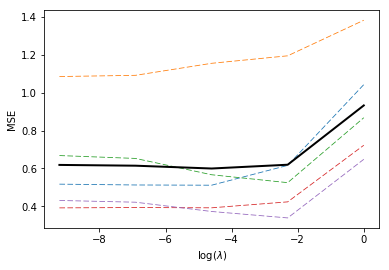

In [3]:
lambdas = np.array([10**k for k in range(-4, 1)])
all_MSEs = cd.cross_validate_coord_descent(X_train, y_train, lambdas, 5, 0.9, random_seed=50)
all_MSEs_mean = np.mean(all_MSEs, axis=0)
cd.plot_MSEs(lambdas, all_MSEs)

In [4]:
lambdas
all_MSEs_mean
max_min_index = np.max(np.where(all_MSEs_mean == all_MSEs_mean.min()))
best_lam = lambdas[max_min_index]
print("best lambda =", best_lam)

array([  1.00000000e-04,   1.00000000e-03,   1.00000000e-02,
         1.00000000e-01,   1.00000000e+00])

array([ 0.6186248 ,  0.61451453,  0.599647  ,  0.61962198,  0.93265135])

best lambda = 0.01


I now run both my cyclic and random coordinate descent functions on the Hitters dataset using the optimal $\lambda$ value I found through cross-validation in the previous bullet (i.e. 0.01).

In [9]:
np.random.seed(50)
betas_cyclic = cd.coorddescent(np.zeros(p_train), X_train, y_train, best_lam, 0.9, 0, desc_type="cyclic")
betas_random = cd.coorddescent(np.zeros(p_train), X_train, y_train, best_lam, 0.9, 0, desc_type="random")

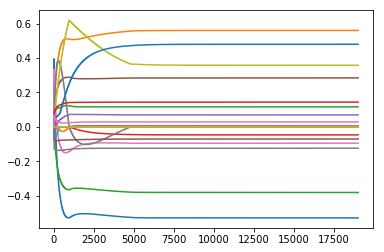

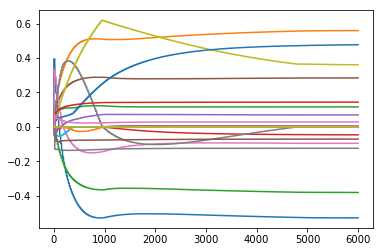

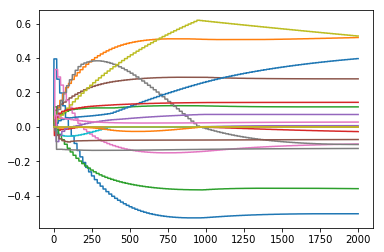

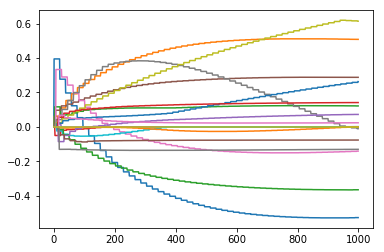

In [34]:
plt.plot(betas_cyclic)
plt.show()
plt.plot(betas_cyclic[0:6000]);
plt.show()
plt.plot(betas_cyclic[0:2000]);
plt.show()
plt.plot(betas_cyclic[0:1000]);

In [35]:
objVals_cyclic = [ cd.compute_obj(b, X_train, y_train, best_lam, 0.9) for b in betas_cyclic ]
objVals_random = [ cd.compute_obj(b, X_train, y_train, best_lam, 0.9) for b in betas_random ]

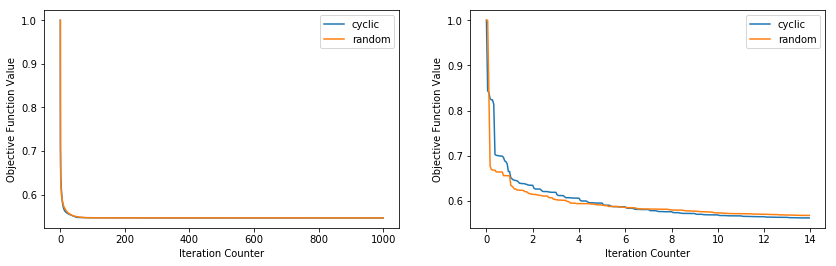

In [36]:
newIter = [i/p_train for i in range(len(objVals_cyclic))]
fig = plt.figure(figsize=[14,4])
ax1 = fig.add_subplot(121)
ax1.plot(newIter, objVals_cyclic)
ax1.plot(newIter, objVals_random)
plt.xlabel('Iteration Counter')
plt.ylabel('Objective Function Value');
ax1.legend(['cyclic','random'])
ax2 = fig.add_subplot(122)
ax2.plot(newIter[0:19*14], objVals_cyclic[0:19*14]);
ax2.plot(newIter[0:19*14], objVals_random[0:19*14]);
plt.xlabel('Iteration Counter')
plt.ylabel('Objective Function Value');
ax2.legend(['cyclic','random']);

# MAKE PREDICTIONS

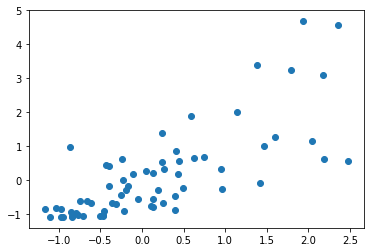

In [17]:
plt.scatter(X_valid.dot(betas_cyclic[-1]), y_valid)